In [1]:
import pandas as pd
import numpy as np
import os
import random
from abc import ABCMeta, abstractmethod
from tqdm.notebook import tqdm

In [2]:
df_guests = pd.read_csv("guests.csv")
df_hotels = pd.read_csv("hotels.csv")
df_prefs = pd.read_csv("preferences.csv")

In [3]:
class BaseAllocation(metaclass=ABCMeta):
    
    def __init__(self, df_guests: pd.DataFrame, df_hotels: pd.DataFrame, df_preferences: pd.DataFrame):
        
        # Create a column based on the position of guest and hotel in the table [0, len of table-1]
        df_guests = df_guests.reset_index().rename(columns={'index': 'guest_index'})
        df_hotels = df_hotels.reset_index().rename(columns={'index': 'hotel_index'})
        
        df_preferences = df_preferences.merge(df_guests[['guest', 'guest_index']], on='guest')
        df_preferences = df_preferences.merge(df_hotels[['hotel', 'hotel_index']], on='hotel')
        
        self.guests = df_guests
        self.hotels = df_hotels
        self.preferences = df_preferences
          
        # initialize the preferences matrix (# guest, # hotel) where 0 if the guest is not assigned to the specific hotel and 1 if he is assigned
        self.pref_matrix = np.zeros((len(df_guests), len(df_hotels)))
        
        # initialize the hotel availability rooms matrix column 1 -> room availability, column 2 -> price, column 3 -> number of rooms assign 
        hotel_matrix = df_hotels.drop(columns=['hotel']).set_index("hotel_index").values
        self.hotel_matrix = np.c_[hotel_matrix, np.zeros(len(df_hotels))]
        

    def _access_pref_matrix(self, guest, hotel):
        self.pref_matrix[guest, hotel] = 1
        self.hotel_matrix[hotel, 2] += 1
        
    
    @abstractmethod
    def assign(self):
        pass

In [4]:
class GuestAllocation(BaseAllocation):
    
    def __init__(self, df_guests: pd.DataFrame, df_hotels: pd.DataFrame, df_preferences: pd.DataFrame):
        super(GuestAllocation, self).__init__(df_guests, df_hotels, df_preferences)
    
    @abstractmethod
    def _define_guest_order():
        pass
    
    def assign(self):
        guest_order = self._define_guest_order()
        for guest in guest_order:
            for hotel in self.pref_by_guest[guest]:
                if self.hotel_matrix[hotel, 2] < self.hotel_matrix[hotel, 0]:
                    self._access_pref_matrix(guest, hotel)
                    break

In [5]:
class HotelAllocation(BaseAllocation):
    
    def __init__(self, df_guests: pd.DataFrame, df_hotels: pd.DataFrame, df_preferences: pd.DataFrame):
        super(HotelAllocation, self).__init__(df_guests, df_hotels, df_preferences)
            
    @abstractmethod
    def _define_hotel_order():
        pass
    
    def assign(self):
        hotel_order = self._define_hotel_order()
        for hotel in hotel_order:
            for guest in self.guest_by_hotel[hotel]:
                if self.hotel_matrix[hotel, 2] == self.hotel_matrix[hotel, 0]:
                    break
                elif self.pref_matrix[guest,:].sum() == 0:
                    self._access_pref_matrix(guest, hotel)

In [6]:
class RandomGuestAllocation(GuestAllocation):
    
    def __init__(self, df_guests: pd.DataFrame, df_hotels: pd.DataFrame, df_preferences: pd.DataFrame):
        super(RandomGuestAllocation, self).__init__(df_guests, df_hotels, df_preferences)
                
    def _define_guest_order(self):
        # Create a dictionary with the raw association between guest and the hotels preferences
        # like {0: [21, 32, 65, ...], 1: [...], ...}
        self.pref_by_guest = self.preferences.groupby("guest_index").agg({"hotel_index":list}).to_dict()["hotel_index"]
        return random.sample(list(self.pref_by_guest.keys()), len(list(self.pref_by_guest.keys())))


In [7]:
class OrderGustAllocation(GuestAllocation):
    
    def __init__(self, df_guests: pd.DataFrame, df_hotels: pd.DataFrame, df_preferences: pd.DataFrame):
        super(OrderGustAllocation, self).__init__(df_guests, df_hotels, df_preferences)
        
        
    def _define_guest_order(self):
        # Create a dictionary with the raw association between guest and the hotels preferences
        # like {0: [21, 32, 65, ...], 1: [...], ...}
        self.pref_by_guest = self.preferences.groupby("guest_index").agg({"hotel_index":list}).to_dict()["hotel_index"]
        return sorted(self.pref_by_guest.keys())


In [8]:
class PriceHotelAllocation(HotelAllocation):
    
    def __init__(self, df_guests: pd.DataFrame, df_hotels: pd.DataFrame, df_preferences: pd.DataFrame):
        super(PriceHotelAllocation, self).__init__(df_guests, df_hotels, df_preferences)
        
    def _define_hotel_order(self):  
        # Create a dictionary with the raw association between guest and the hotels preferences
        # like {21: [0, 2, 5, ...], 65: [...], ...}
        guest_by_hotel = self.preferences.groupby("hotel_index").agg({"guest_index":list}).to_dict()["guest_index"]
        self.guest_by_hotel = {key: sorted(values) for key, values in guest_by_hotel.items()}
        
        return self.hotels.sort_values('price')['hotel_index'].tolist()
    

In [9]:
class AvailabilityHotelAllocation(HotelAllocation):
    
    def __init__(self, df_guests: pd.DataFrame, df_hotels: pd.DataFrame, df_preferences: pd.DataFrame):
        super(AvailabilityHotelAllocation, self).__init__(df_guests, df_hotels, df_preferences)
        
    def _define_hotel_order(self): 
        # Create a dictionary with the raw association between guest and the hotels preferences
        # like {21: [0, 2, 5, ...], 65: [...], ...}
        guest_by_hotel = self.preferences.groupby("hotel_index").agg({"guest_index":list}).to_dict()["guest_index"]
        self.guest_by_hotel = {key: sorted(values) for key, values in guest_by_hotel.items()}
        
        return self.hotels.sort_values('rooms')['hotel_index'].tolist()
    

In [13]:
metric = list()
for i in tqdm(range(1000)):
    a = RandomGuestAllocation(df_guests, df_hotels, df_prefs)
    a.assign()
    metric.append(a.pref_matrix.sum(1).sum())

  0%|          | 0/1000 [00:00<?, ?it/s]

<AxesSubplot:>

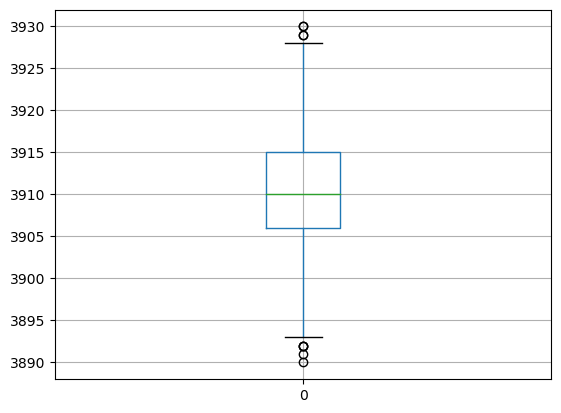

In [14]:
pd.DataFrame(metric).boxplot()

In [10]:
b = OrderGustAllocation(df_guests, df_hotels, df_prefs)
b.assign()
b.pref_matrix.sum(1).sum()

3926.0

In [11]:
c = PriceHotelAllocation(df_guests, df_hotels, df_prefs)

c.assign()

c.pref_matrix.sum(1).sum()

3925.0

In [12]:
d = AvailabilityHotelAllocation(df_guests, df_hotels, df_prefs)

d.assign()

d.pref_matrix.sum(1).sum()

3874.0